In [1]:
!pip install gdown
!pip install tensorflow-gpu

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\leste\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 425, in _error_catcher
    yield
  File "C:\Users\leste\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\leste\Anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\leste\Anaconda3\lib\http\client.py", line 457, in read
    n = self.readinto(b)
  File "C:\Users\leste\Anaconda3\lib\http\client.py", line 501, in readinto
    n = self.fp.readinto(b)


  File "C:\Users\leste\Anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\leste\Anaconda3\lib\ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\leste\Anaconda3\lib\ssl.py", line 929, in read
    return self._sslobj.read(len, buffer)
socket.timeout: The read operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\leste\Anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 186, in _main
    status = self.run(options, args)
  File "C:\Users\leste\Anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 331, in run
    resolver.resolve(requirement_set)
  File "C:\Users\leste\Anaconda3\lib\site-packages\pip\_internal\legacy_resolve.py", line 177, in resolve
    discovered_reqs.extend(self._resolve_one(requirement_set, req))
  File "C:\Users\leste\Anaconda3\lib\site-packages\pip\_internal\legacy_

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: C:\Users\leste\OneDrive\Desktop\LSTM-Autoencoder\spx.csv

  0%|          | 0.00/152k [00:00<?, ?B/s]
100%|##########| 152k/152k [00:01<00:00, 95.3kB/s]
100%|##########| 152k/152k [00:01<00:00, 95.3kB/s]


In [4]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [5]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


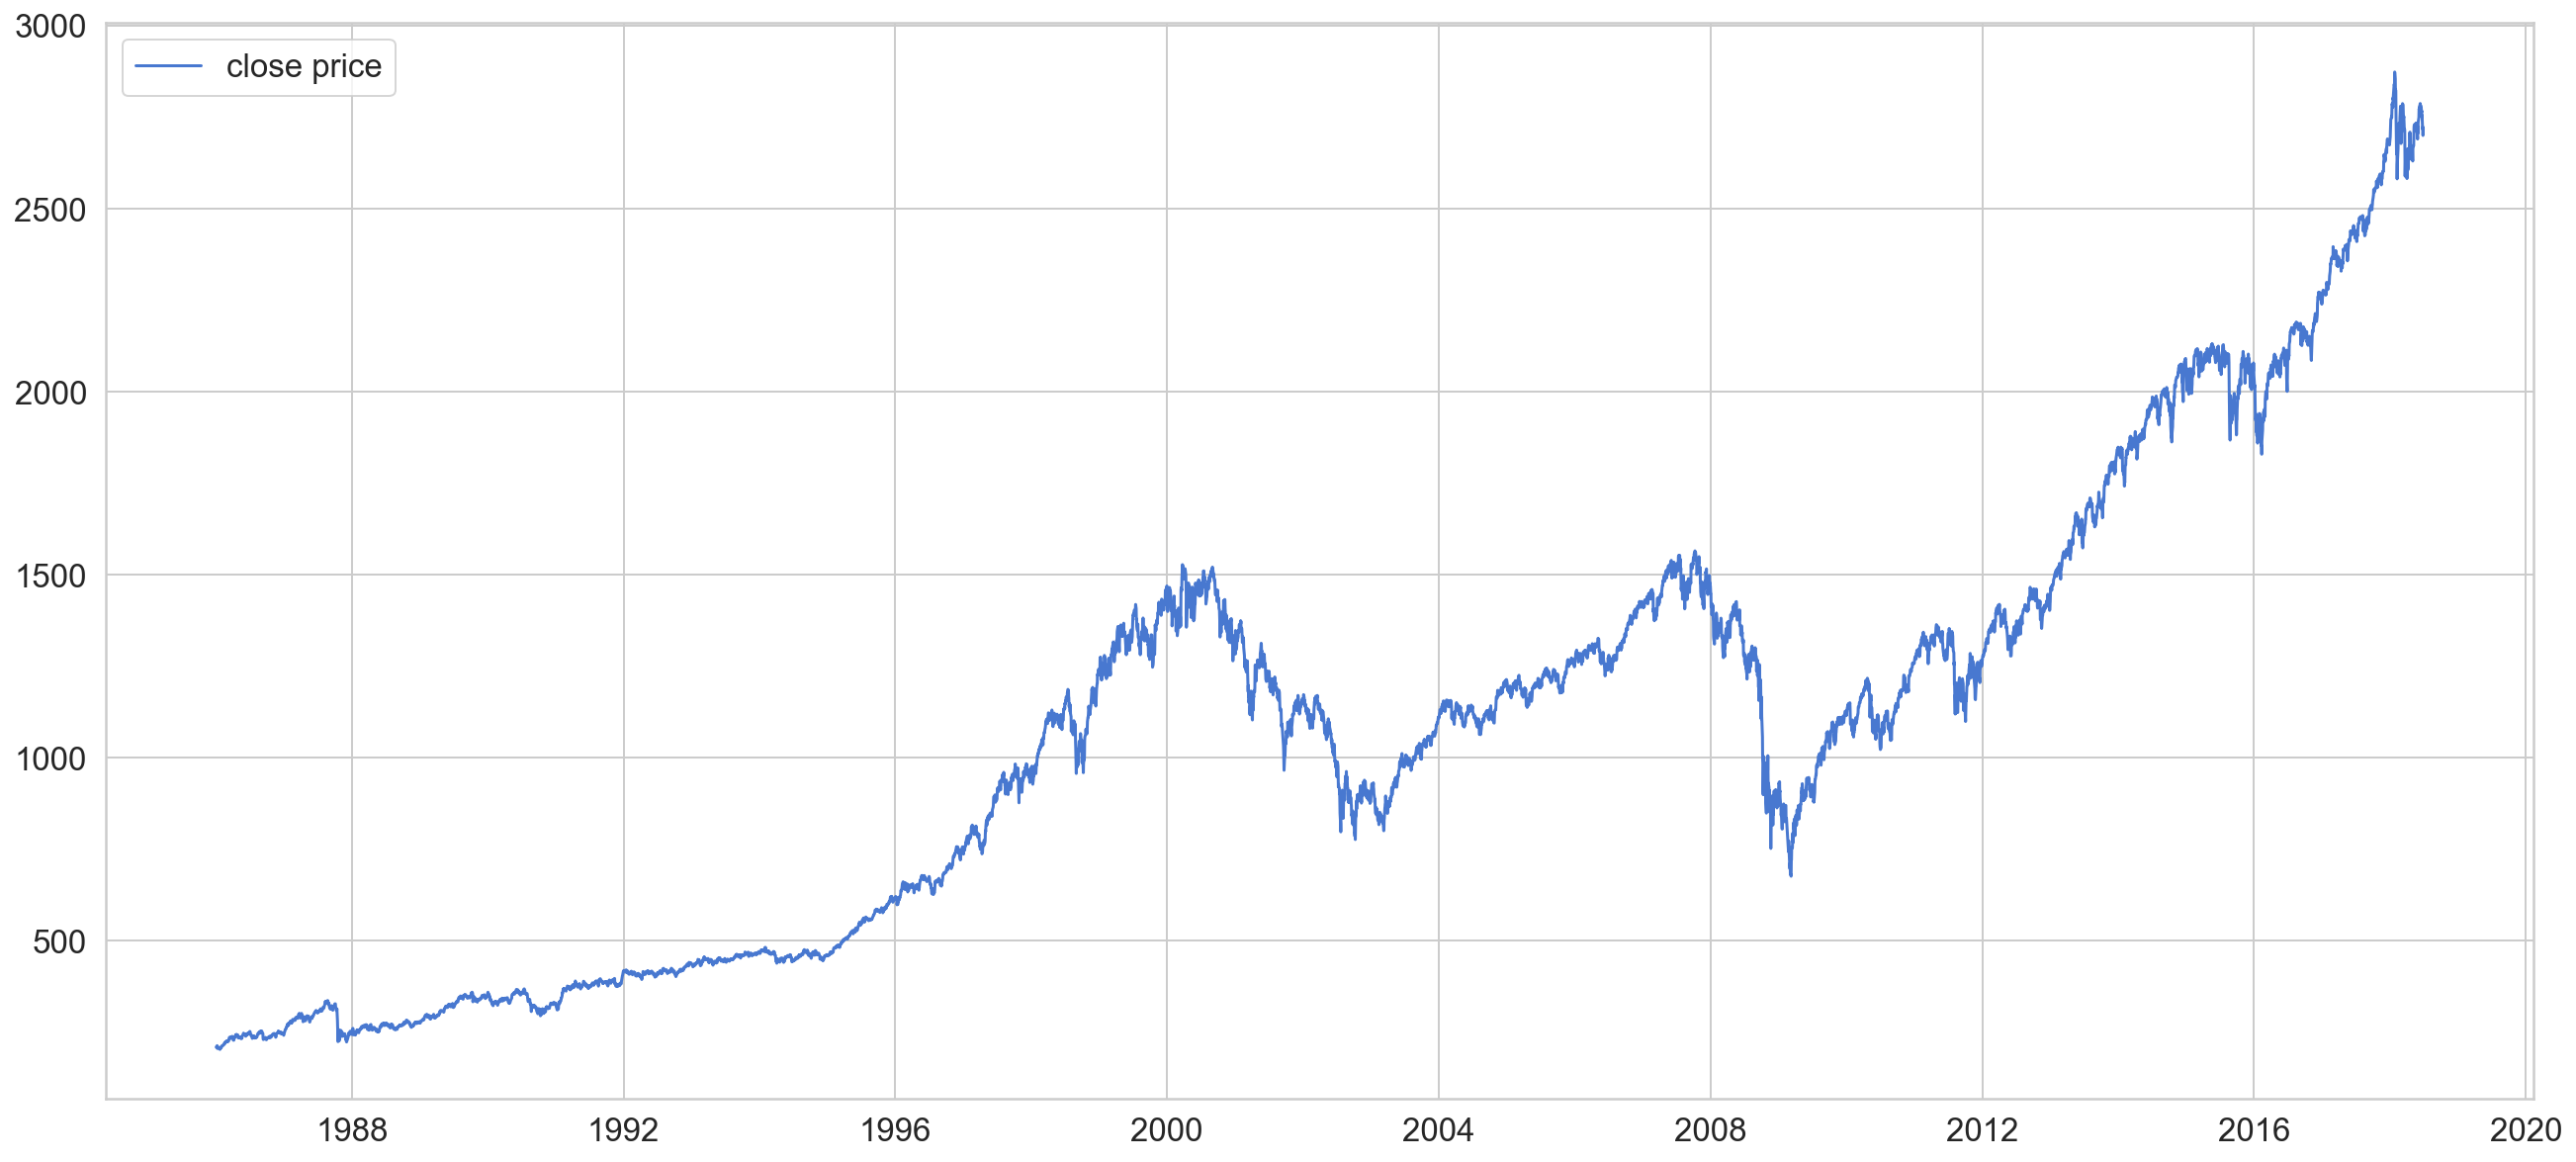

In [6]:
plt.plot(df, label='close price')
plt.legend();

In [7]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

C:\Users\leste\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\leste\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [11]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 6976 samples, validate on 776 samples
Epoch 1/10
6976/6976 [==============================] - 7s 1ms/sample - loss: 0.1672 - val_loss: 0.1805
Epoch 2/10
6976/6976 [==============================] - 5s 762us/sample - loss: 0.0915 - val_loss: 0.2030
Epoch 3/10
6976/6976 [==============================] - 5s 727us/sample - loss: 0.0953 - val_loss: 0.1347
Epoch 4/10
6976/6976 [==============================] - 5s 667us/sample - loss: 0.0841 - val_loss: 0.1933
Epoch 5/10
6976/6976 [==============================] - 5s 661us/sample - loss: 0.0832 - val_loss: 0.1901
Epoch 6/10
6976/6976 [==============================] - 5s 661us/sample - loss: 0.0852 - val_loss: 0.2349
Epoch 7/10
6976/6976 [==============================] - 5s 660us/sample - loss: 0.0837 - val_loss: 0.1725
Epoch 8/10
6976/6976 [==============================] - 5s 661us/sample - loss: 0.0841 - val_loss: 0.1333
Epoch 9/10
6976/6976 [==============================] - 5s 659us/sample - loss: 0.0785 - val_loss: 0.1373
E

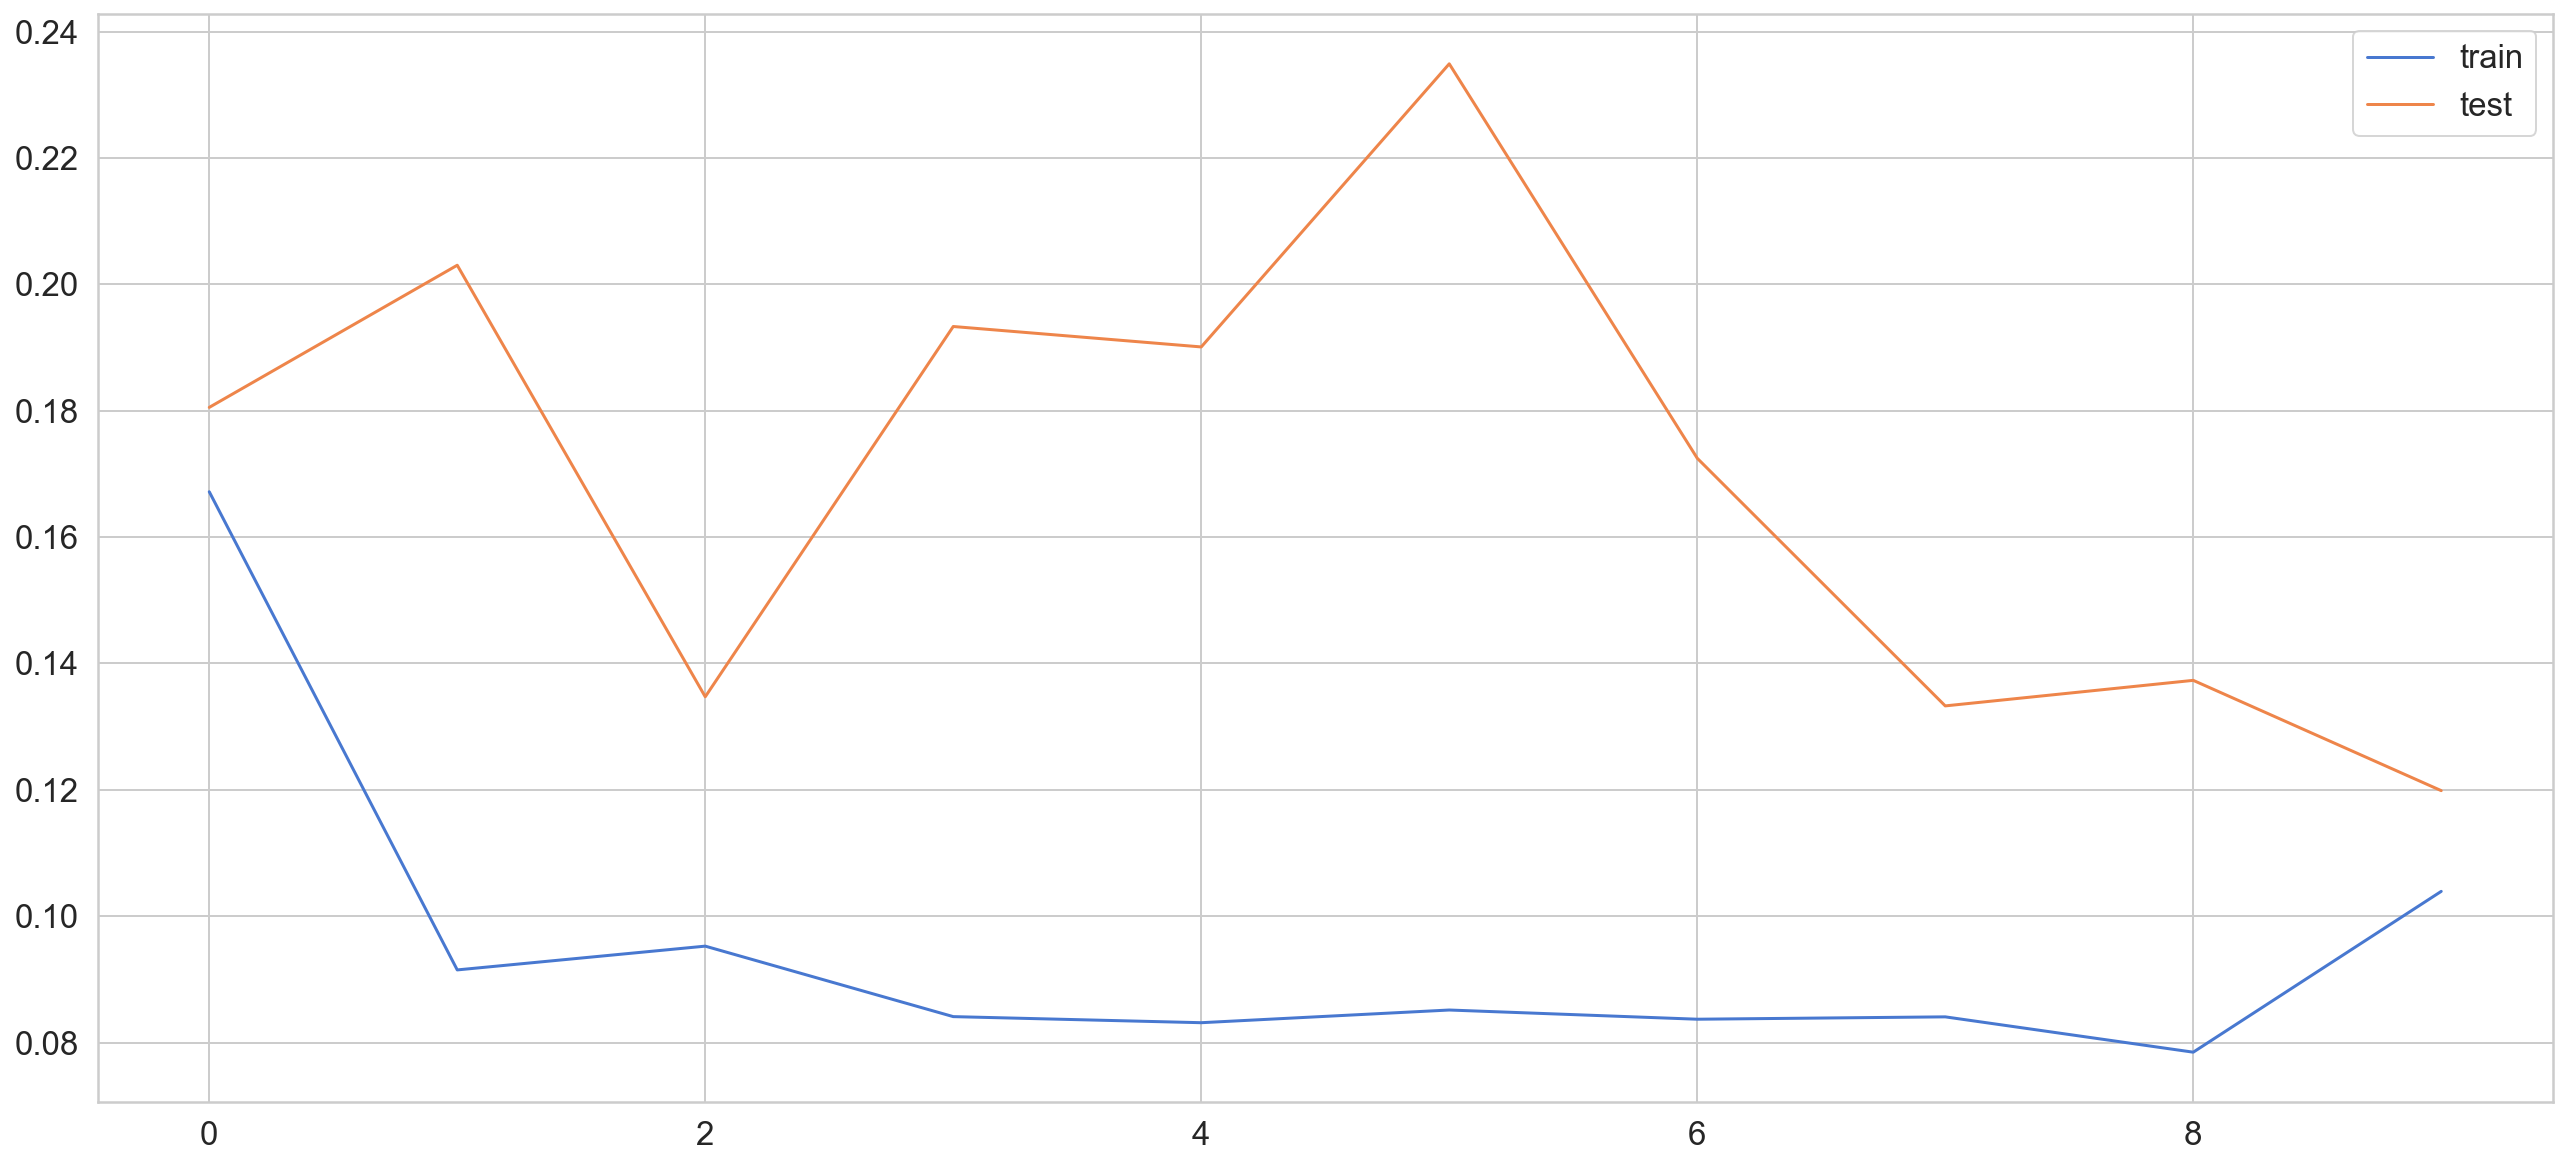

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [14]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

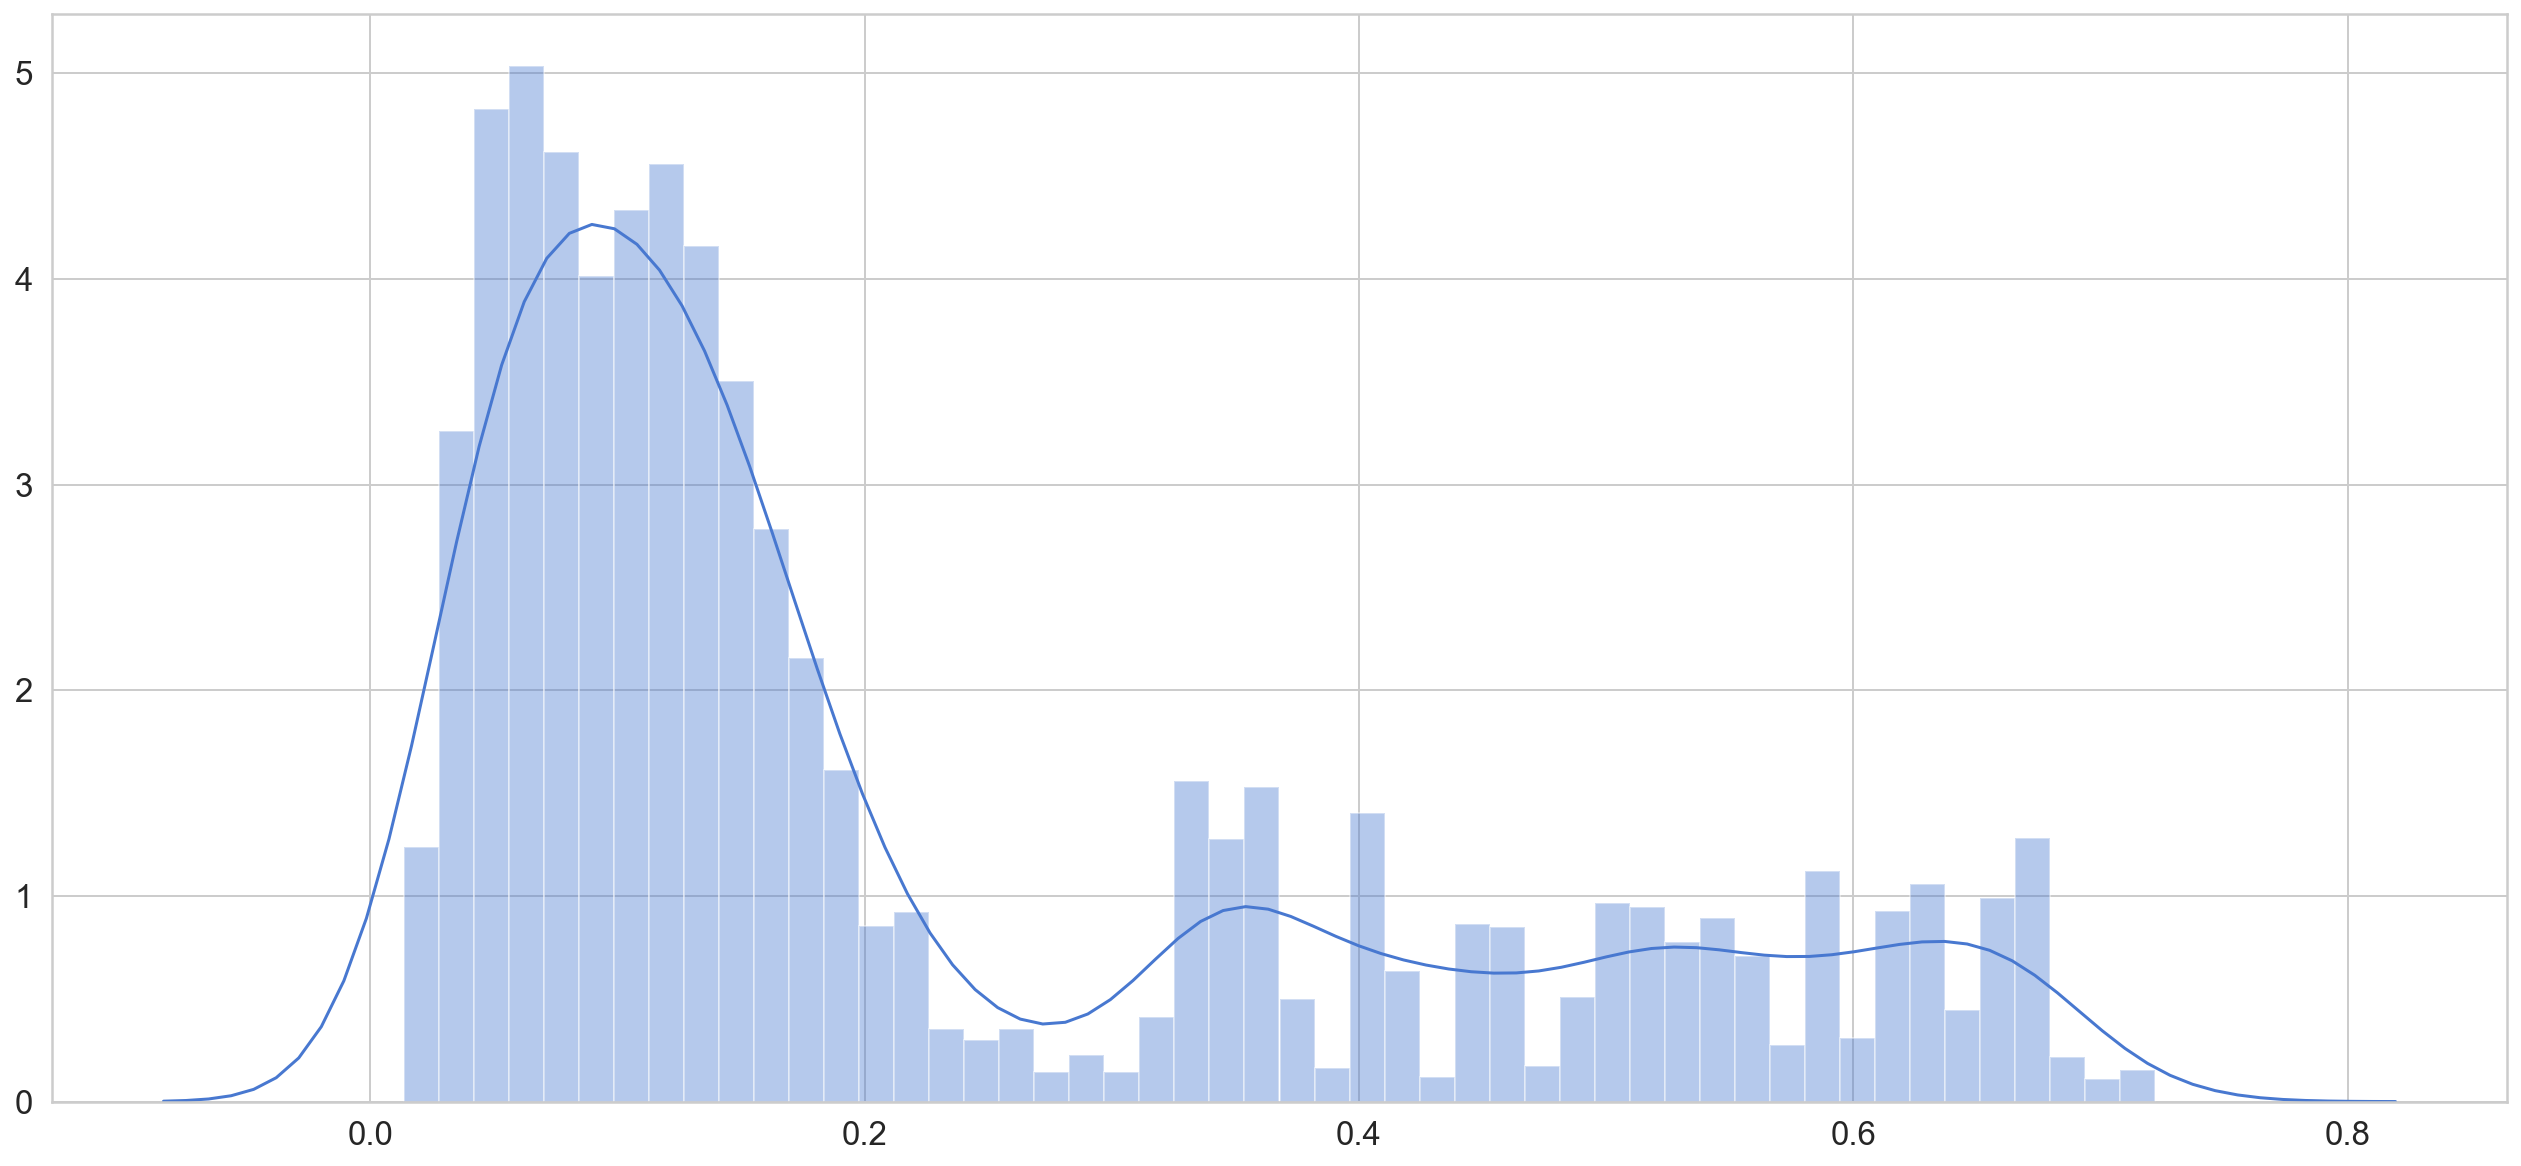

In [15]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [16]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [17]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

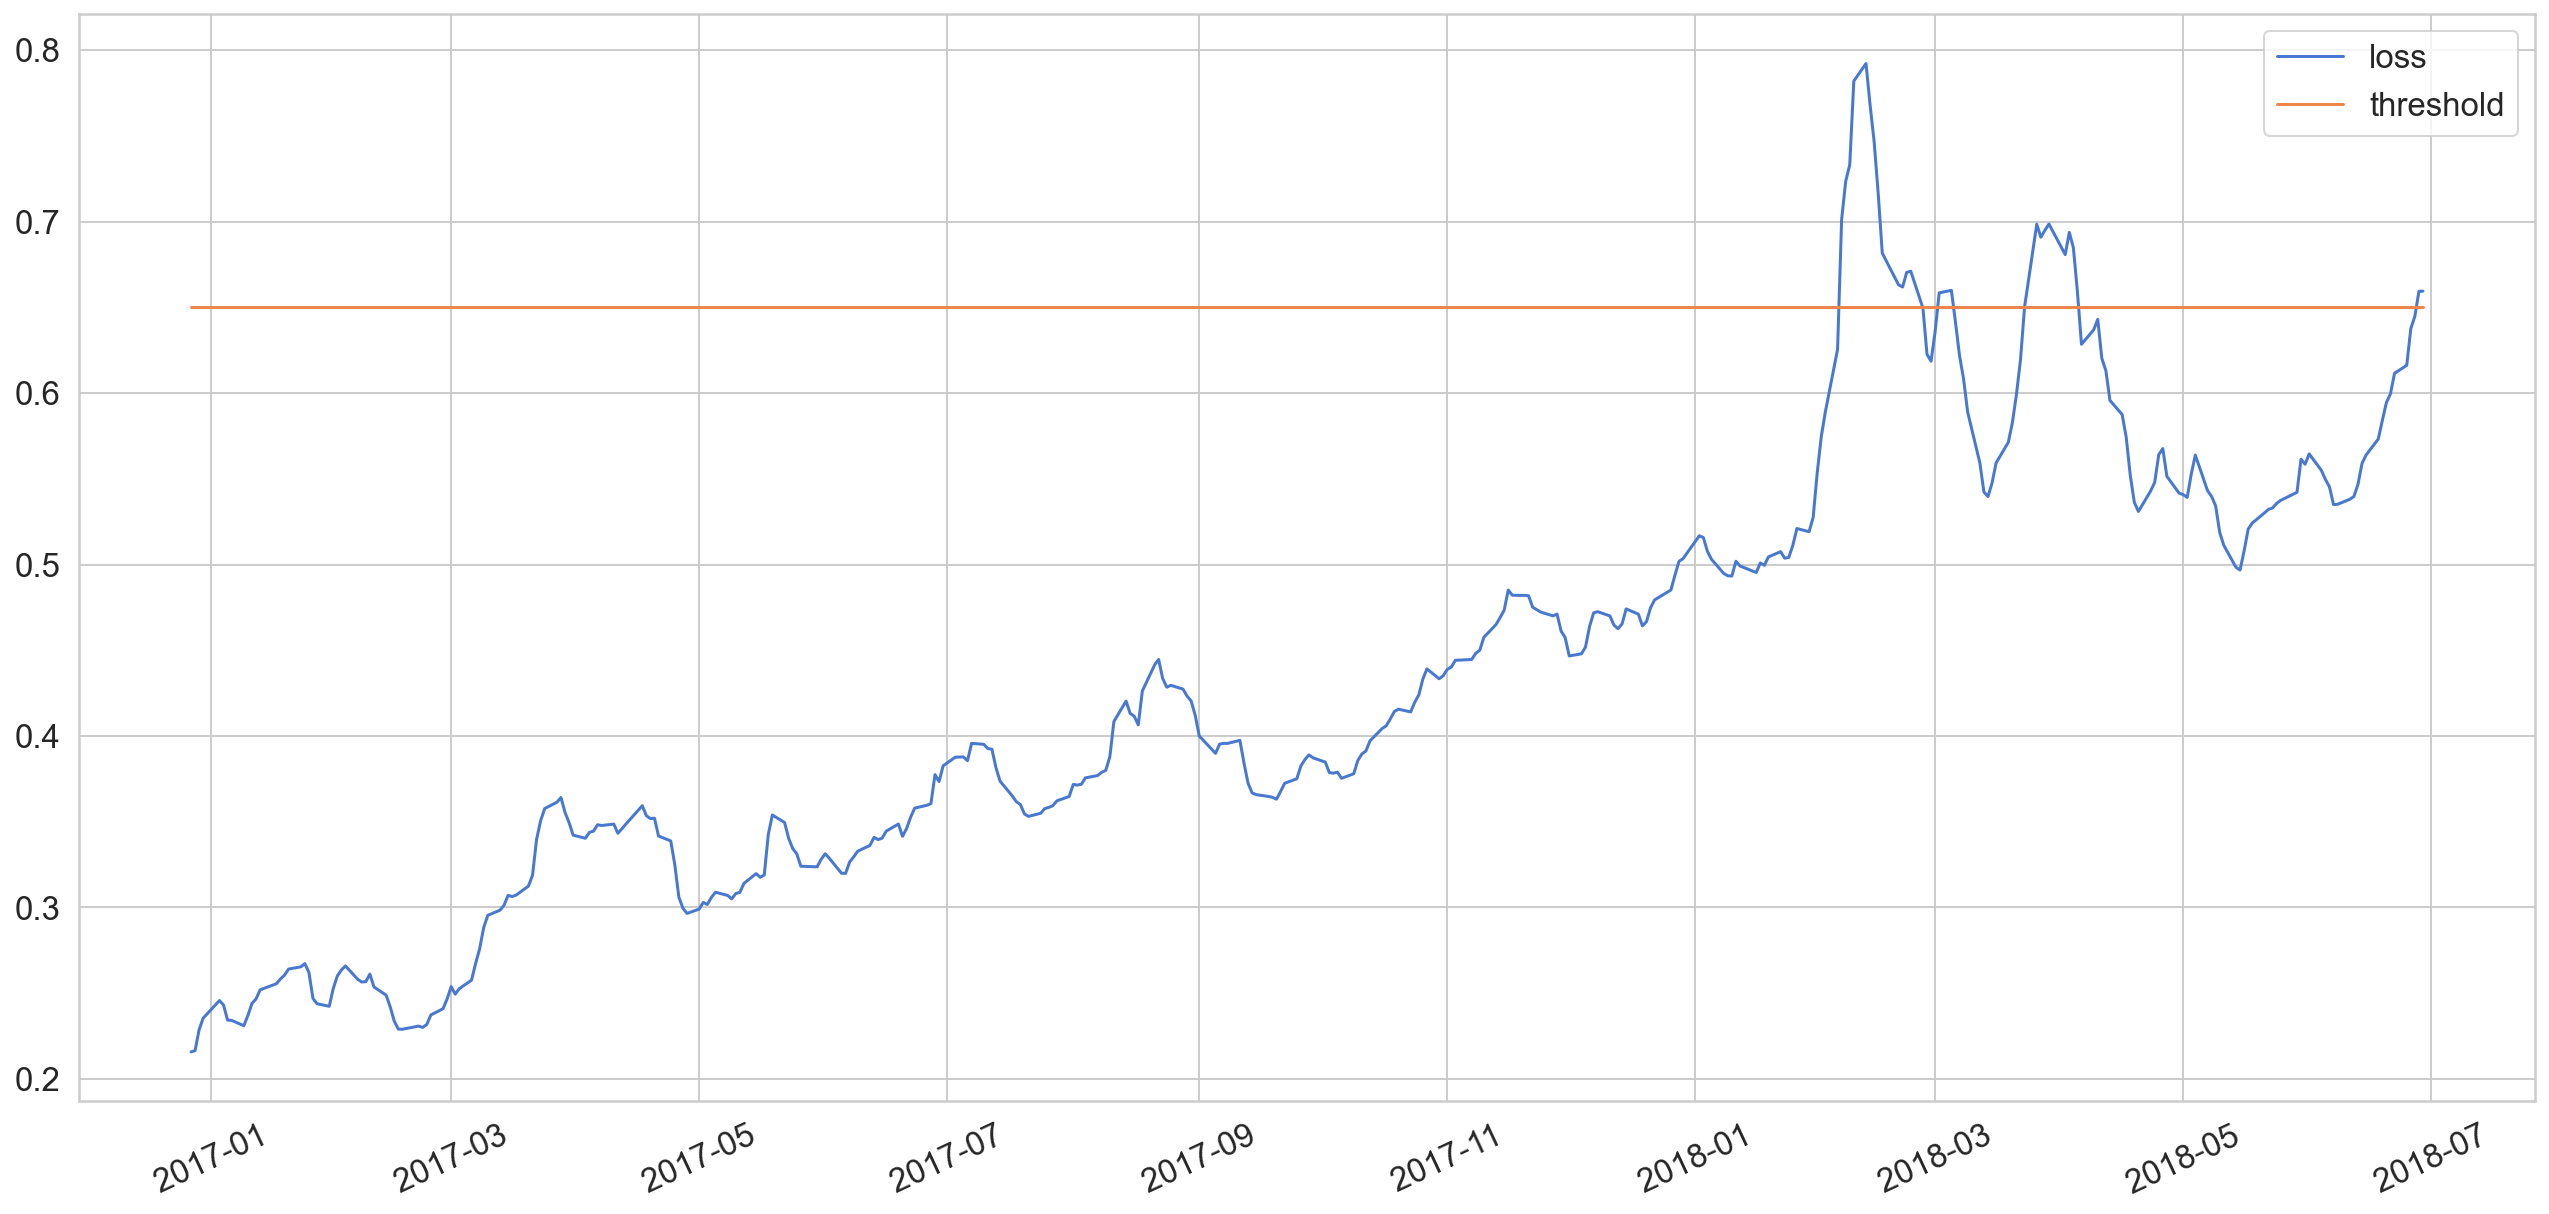

In [18]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [19]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.701135,0.65,True,3.193456
2018-02-07,0.723474,0.65,True,3.168136
2018-02-08,0.733227,0.65,True,2.979068
2018-02-09,0.782006,0.65,True,3.051476
2018-02-12,0.792227,0.65,True,3.119939


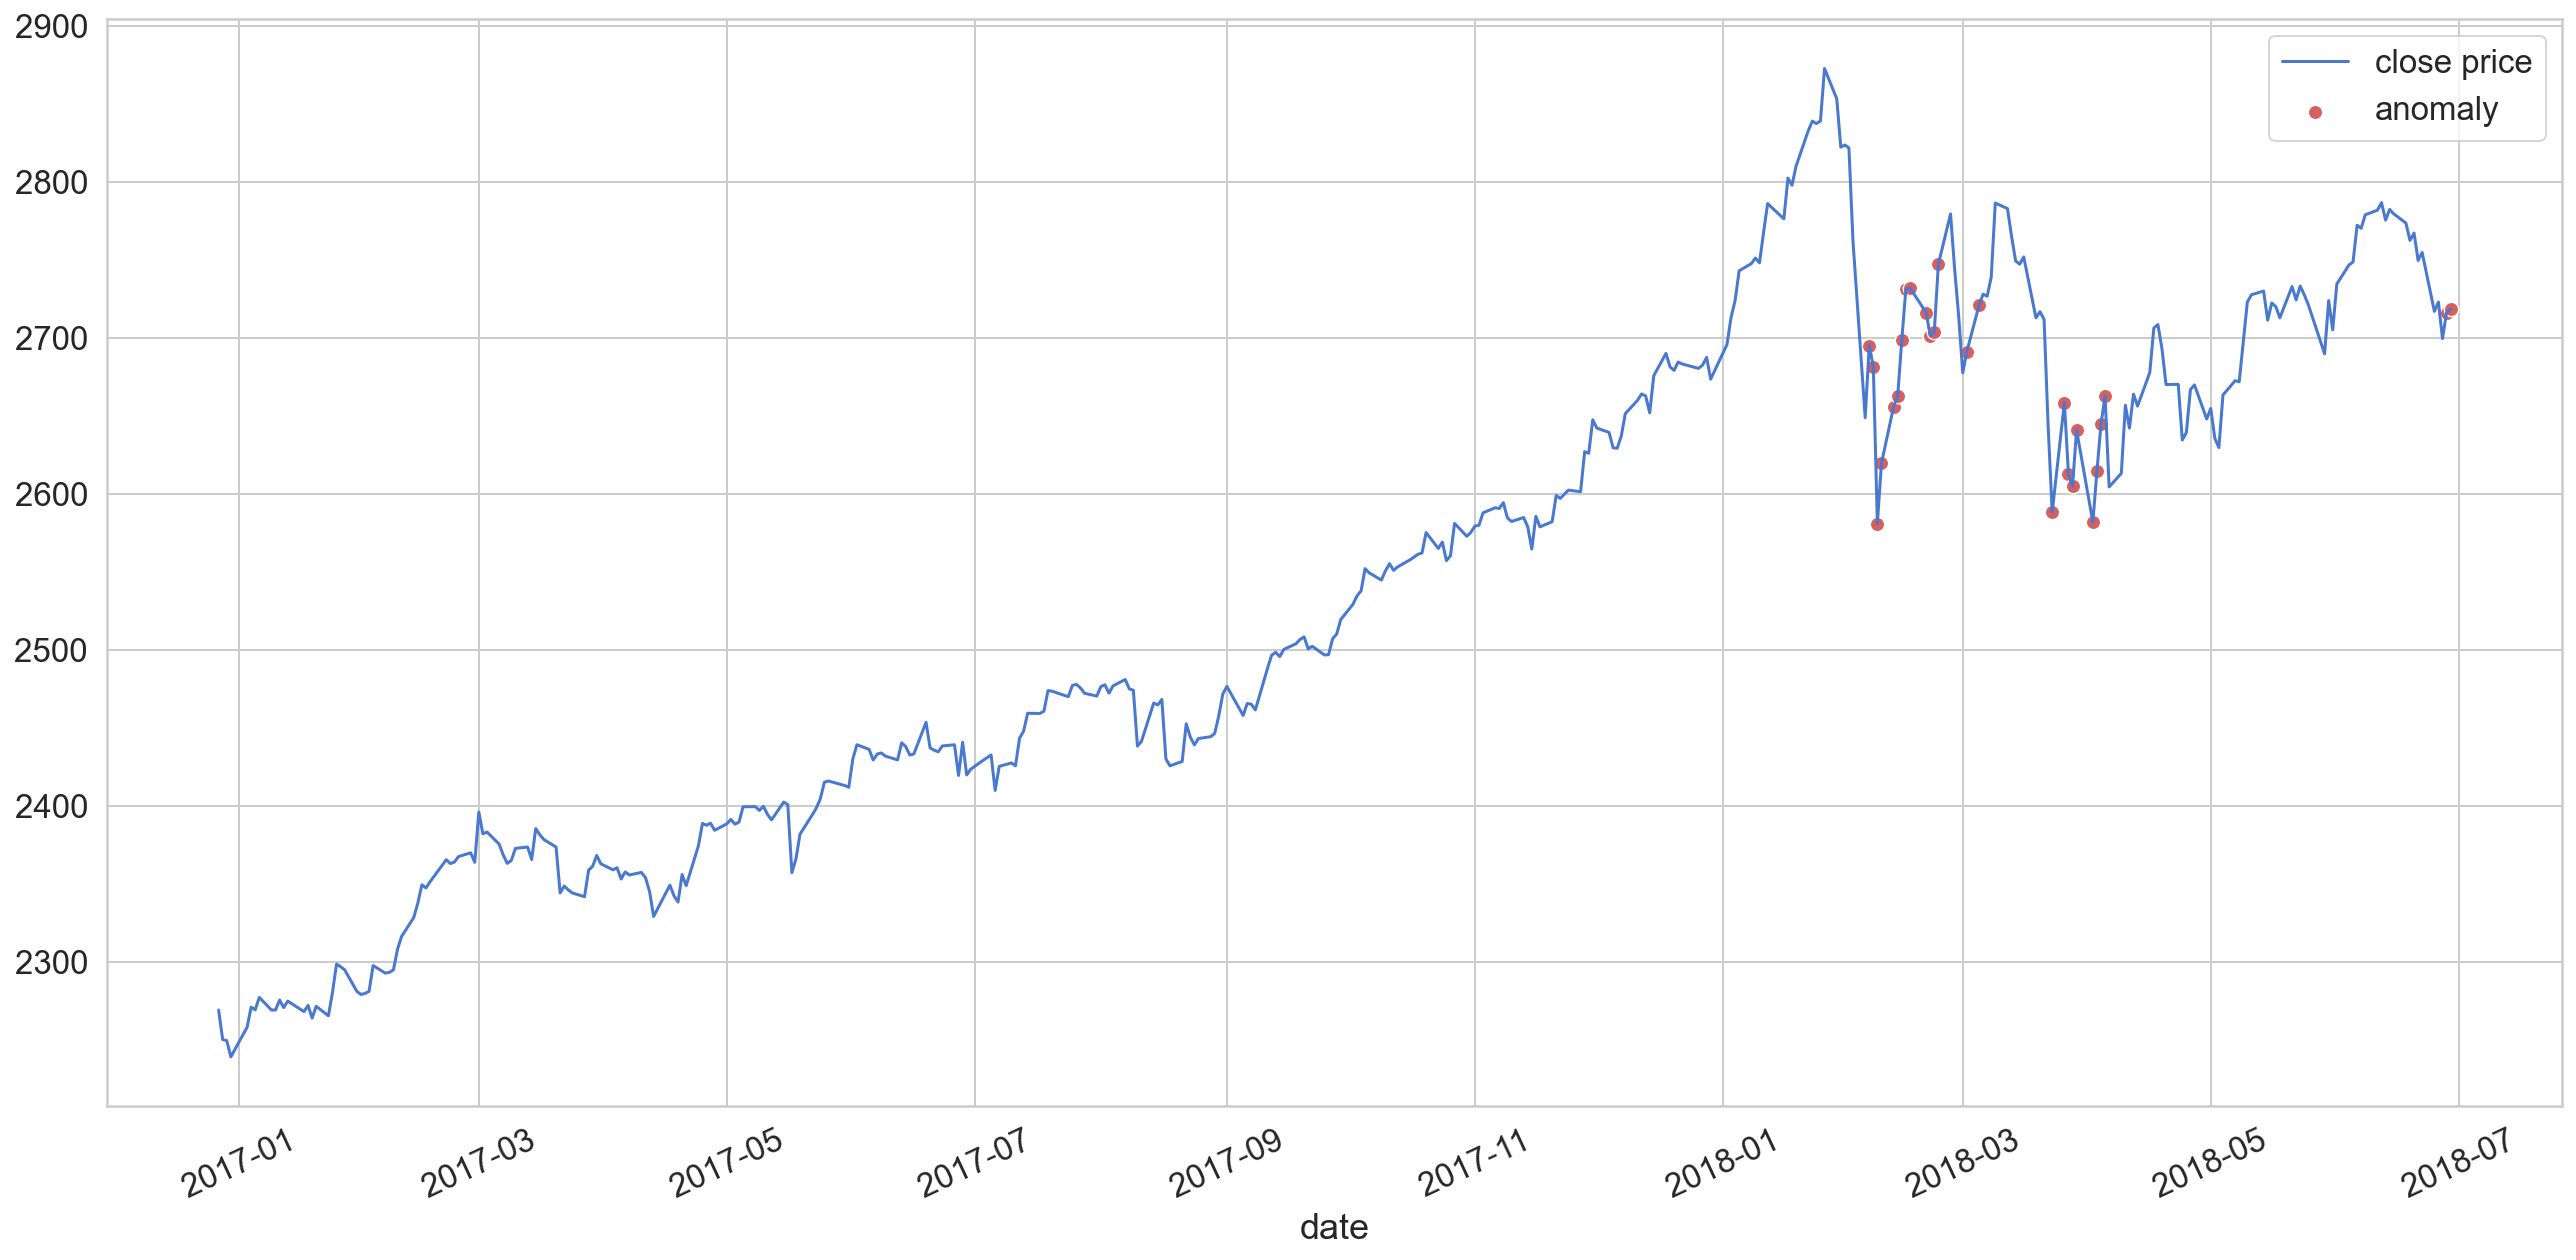

In [20]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();